In [1]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

from scipy.stats import norm, skewnorm

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import KoopmanProb
from model_objs import SkewNormalNLL

In [4]:
all_data = np.load("FPUT.npy")

In [5]:
point_idx = 19
x = np.transpose(np.array([all_data[point_idx]], dtype=np.float64))

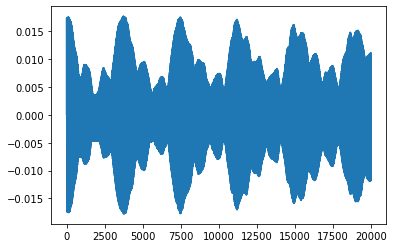

In [6]:
%matplotlib inline
plt.plot(x)

In [7]:
x_original = x
mean = np.mean(x, axis=0)
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = (x - np.matlib.repmat(mean, x.shape[0], 1)) / np.matlib.repmat(rnge, x.shape[0], 1)
print("x", x.shape)

x (20000, 1)


In [27]:
data_name = "FPUT_idx" + str(point_idx)

train_through = 7500
train_start = 0
delay = 0
test_length = 5000
x = x[train_start:]
predict_through = train_through + test_length + delay  
x = x[:predict_through]
xt = x[:train_through]

num_freqs = [5, 5, 5]
num_fourier = 5
hard_code = [3700]
mu_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}mu.npy"
sigma_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}sigma.npy"
alpha_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}alpha.npy"
print("x", x.shape)
print("xt", xt.shape)

x (12500, 1)
xt (7500, 1)


In [28]:
model = SkewNormalNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [29]:
k.find_fourier_omegas(xt, hard_code=hard_code)

fourier periods: tensor([  21.9298,    7.3242, 3699.9997], dtype=torch.float64)


tensor([0.2865, 0.8579, 0.0017], dtype=torch.float64)

In [30]:
k.fit(xt, iterations=400, interval=10, verbose=True, cutoff=0, weight_decay=0, lr_theta=1e-4, lr_omega=1e-6);

Iteration  0
tensor([  21.9298,    7.3242, 3699.9998,   21.9298,    7.3242, 3699.9998,
          21.9298,    7.3242, 3699.9998])
Setting periods to tensor([  21.9298,    7.3242, 3700.0159,   21.9298,    7.3242, 3700.9248,
          21.9298,    7.3242, 3699.9902], grad_fn=<MulBackward0>)
Loss:  2.6234718749667496
Iteration  1
tensor([  21.9298,    7.3242, 3700.0159,   21.9298,    7.3242, 3700.9248,
          21.9298,    7.3242, 3699.9902])
Setting periods to tensor([  21.9298,    7.3242, 3700.0332,   21.9298,    7.3242, 3701.8743,
          21.9298,    7.3242, 3699.9790], grad_fn=<MulBackward0>)
Loss:  2.558195303795792
Iteration  2
tensor([  21.9298,    7.3242, 3700.0332,   21.9298,    7.3242, 3701.8743,
          21.9298,    7.3242, 3699.9790])
Setting periods to tensor([  21.9298,    7.3242, 3700.0510,   21.9298,    7.3242, 3702.8687,
          21.9298,    7.3242, 3699.9675], grad_fn=<MulBackward0>)
Loss:  2.489629798597691
Iteration  3
tensor([  21.9298,    7.3242, 3700.0510,   21.9

Setting periods to tensor([  21.9335,    7.3243, 3696.1858,   21.9297,    7.3242, 3776.5259,
          21.9298,    7.3242, 3702.6731], grad_fn=<MulBackward0>)
Loss:  -1.0006009957809392
Iteration  27
tensor([  21.9335,    7.3243, 3696.1858,   21.9297,    7.3242, 3776.5259,
          21.9298,    7.3242, 3702.6731])
Setting periods to tensor([  21.9340,    7.3243, 3695.8525,   21.9297,    7.3242, 3784.4338,
          21.9297,    7.3242, 3703.2598], grad_fn=<MulBackward0>)
Loss:  -1.0197332894791948
Iteration  28
tensor([  21.9340,    7.3243, 3695.8525,   21.9297,    7.3242, 3784.4338,
          21.9297,    7.3242, 3703.2598])
Setting periods to tensor([  21.9343,    7.3243, 3695.7212,   21.9297,    7.3242, 3792.0681,
          21.9297,    7.3242, 3703.8528], grad_fn=<MulBackward0>)
Loss:  -1.034883459254888
Iteration  29
tensor([  21.9343,    7.3243, 3695.7212,   21.9297,    7.3242, 3792.0681,
          21.9297,    7.3242, 3703.8528])
Setting periods to tensor([  21.9348,    7.3243, 3695

Setting periods to tensor([  21.9392,    7.3252, 3750.6245,   21.9294,    7.3243, 3874.5632,
          21.9280,    7.3242, 3715.4397], grad_fn=<MulBackward0>)
Loss:  -1.2616883295854757
Iteration  53
tensor([  21.9392,    7.3252, 3750.6245,   21.9294,    7.3243, 3874.5632,
          21.9280,    7.3242, 3715.4397])
Setting periods to tensor([  21.9393,    7.3253, 3754.2473,   21.9294,    7.3243, 3873.8813,
          21.9279,    7.3242, 3715.7703], grad_fn=<MulBackward0>)
Loss:  -1.272102284429889
Iteration  54
tensor([  21.9393,    7.3253, 3754.2473,   21.9294,    7.3243, 3873.8813,
          21.9279,    7.3242, 3715.7703])
Setting periods to tensor([  21.9395,    7.3254, 3758.4939,   21.9294,    7.3243, 3873.3745,
          21.9279,    7.3242, 3716.0908], grad_fn=<MulBackward0>)
Loss:  -1.2817294638326295
Iteration  55
tensor([  21.9395,    7.3254, 3758.4939,   21.9294,    7.3243, 3873.3745,
          21.9279,    7.3242, 3716.0908])
Setting periods to tensor([  21.9396,    7.3254, 3762

Setting periods to tensor([  21.9431,    7.3269, 3857.2205,   21.9293,    7.3243, 3816.3289,
          21.9269,    7.3242, 3721.3181], grad_fn=<MulBackward0>)
Loss:  -1.5418958257538733
Iteration  79
tensor([  21.9431,    7.3269, 3857.2205,   21.9293,    7.3243, 3816.3289,
          21.9269,    7.3242, 3721.3181])
Setting periods to tensor([  21.9432,    7.3269, 3860.7275,   21.9293,    7.3243, 3813.7808,
          21.9269,    7.3242, 3721.4629], grad_fn=<MulBackward0>)
Loss:  -1.5530502818458818
Iteration  80
tensor([  21.9432,    7.3269, 3860.7275,   21.9293,    7.3243, 3813.7808,
          21.9269,    7.3242, 3721.4629])
Setting periods to tensor([  21.9432,    7.3270, 3861.6782,   21.9293,    7.3243, 3810.6506,
          21.9269,    7.3242, 3721.6289], grad_fn=<MulBackward0>)
Loss:  -1.5645050339299265
Iteration  81
tensor([  21.9432,    7.3270, 3861.6782,   21.9293,    7.3243, 3810.6506,
          21.9269,    7.3242, 3721.6289])
Setting periods to tensor([  21.9433,    7.3271, 386

Setting periods to tensor([  21.9437,    7.3278, 3875.6504,   21.9296,    7.3243, 3766.9458,
          21.9270,    7.3241, 3723.6433], grad_fn=<MulBackward0>)
Loss:  -1.7774439226389924
Iteration  105
tensor([  21.9437,    7.3278, 3875.6504,   21.9296,    7.3243, 3766.9458,
          21.9270,    7.3241, 3723.6433])
Setting periods to tensor([  21.9438,    7.3278, 3870.8953,   21.9296,    7.3243, 3766.4119,
          21.9271,    7.3241, 3723.6514], grad_fn=<MulBackward0>)
Loss:  -1.782507484962325
Iteration  106
tensor([  21.9438,    7.3278, 3870.8953,   21.9296,    7.3243, 3766.4119,
          21.9271,    7.3241, 3723.6514])
Setting periods to tensor([  21.9439,    7.3279, 3870.7705,   21.9296,    7.3243, 3766.2070,
          21.9271,    7.3241, 3723.6887], grad_fn=<MulBackward0>)
Loss:  -1.7858814184993483
Iteration  107
tensor([  21.9439,    7.3279, 3870.7705,   21.9296,    7.3243, 3766.2070,
          21.9271,    7.3241, 3723.6887])
Setting periods to tensor([  21.9438,    7.3279, 3

Setting periods to tensor([  21.9434,    7.3280, 3865.4810,   21.9299,    7.3243, 3760.8884,
          21.9285,    7.3241, 3724.0583], grad_fn=<MulBackward0>)
Loss:  -1.8919524013326994
Iteration  131
tensor([  21.9434,    7.3280, 3865.4810,   21.9299,    7.3243, 3760.8884,
          21.9285,    7.3241, 3724.0583])
Setting periods to tensor([  21.9433,    7.3280, 3868.5305,   21.9300,    7.3243, 3760.5632,
          21.9286,    7.3241, 3724.0898], grad_fn=<MulBackward0>)
Loss:  -1.8936356207032952
Iteration  132
tensor([  21.9433,    7.3280, 3868.5305,   21.9300,    7.3243, 3760.5632,
          21.9286,    7.3241, 3724.0898])
Setting periods to tensor([  21.9433,    7.3280, 3863.7441,   21.9300,    7.3243, 3761.0505,
          21.9287,    7.3241, 3724.1211], grad_fn=<MulBackward0>)
Loss:  -1.9010271627342847
Iteration  133
tensor([  21.9433,    7.3280, 3863.7441,   21.9300,    7.3243, 3761.0505,
          21.9287,    7.3241, 3724.1211])
Setting periods to tensor([  21.9434,    7.3280, 

Setting periods to tensor([  21.9428,    7.3281, 3852.0154,   21.9308,    7.3243, 3758.6162,
          21.9315,    7.3241, 3725.6548], grad_fn=<MulBackward0>)
Loss:  -1.9881381052893987
Iteration  157
tensor([  21.9428,    7.3281, 3852.0154,   21.9308,    7.3243, 3758.6162,
          21.9315,    7.3241, 3725.6548])
Setting periods to tensor([  21.9427,    7.3281, 3840.8245,   21.9309,    7.3243, 3758.6396,
          21.9316,    7.3241, 3725.7043], grad_fn=<MulBackward0>)
Loss:  -1.9949896875884026
Iteration  158
tensor([  21.9427,    7.3281, 3840.8245,   21.9309,    7.3243, 3758.6396,
          21.9316,    7.3241, 3725.7043])
Setting periods to tensor([  21.9429,    7.3281, 3842.8318,   21.9309,    7.3243, 3758.5120,
          21.9317,    7.3241, 3725.7878], grad_fn=<MulBackward0>)
Loss:  -2.00065710010883
Iteration  159
tensor([  21.9429,    7.3281, 3842.8318,   21.9309,    7.3243, 3758.5120,
          21.9317,    7.3241, 3725.7878])
Setting periods to tensor([  21.9428,    7.3281, 38

Setting periods to tensor([  21.9426,    7.3282, 3823.7395,   21.9319,    7.3243, 3750.9053,
          21.9348,    7.3241, 3727.8281], grad_fn=<MulBackward0>)
Loss:  -2.1002533332719815
Iteration  183
tensor([  21.9426,    7.3282, 3823.7395,   21.9319,    7.3243, 3750.9053,
          21.9348,    7.3241, 3727.8281])
Setting periods to tensor([  21.9425,    7.3282, 3821.8186,   21.9319,    7.3243, 3750.6123,
          21.9349,    7.3241, 3727.9438], grad_fn=<MulBackward0>)
Loss:  -2.1061328458918873
Iteration  184
tensor([  21.9425,    7.3282, 3821.8186,   21.9319,    7.3243, 3750.6123,
          21.9349,    7.3241, 3727.9438])
Setting periods to tensor([  21.9426,    7.3282, 3817.2124,   21.9320,    7.3243, 3750.1233,
          21.9350,    7.3241, 3727.9988], grad_fn=<MulBackward0>)
Loss:  -2.1108552952351087
Iteration  185
tensor([  21.9426,    7.3282, 3817.2124,   21.9320,    7.3243, 3750.1233,
          21.9350,    7.3241, 3727.9988])
Setting periods to tensor([  21.9426,    7.3282, 

Setting periods to tensor([  21.9424,    7.3282, 3804.7231,   21.9325,    7.3243, 3745.0310,
          21.9376,    7.3241, 3730.4292], grad_fn=<MulBackward0>)
Loss:  -2.199570686467665
Iteration  209
tensor([  21.9424,    7.3282, 3804.7231,   21.9325,    7.3243, 3745.0310,
          21.9376,    7.3241, 3730.4292])
Setting periods to tensor([  21.9424,    7.3282, 3794.0789,   21.9325,    7.3243, 3744.8008,
          21.9377,    7.3241, 3730.5203], grad_fn=<MulBackward0>)
Loss:  -2.198550673144613
Iteration  210
tensor([  21.9424,    7.3282, 3794.0789,   21.9325,    7.3243, 3744.8008,
          21.9377,    7.3241, 3730.5203])
Setting periods to tensor([  21.9425,    7.3282, 3800.5847,   21.9325,    7.3243, 3744.9648,
          21.9378,    7.3241, 3730.6428], grad_fn=<MulBackward0>)
Loss:  -2.2040639558689796
Iteration  211
tensor([  21.9425,    7.3282, 3800.5847,   21.9325,    7.3243, 3744.9648,
          21.9378,    7.3241, 3730.6428])
Setting periods to tensor([  21.9426,    7.3282, 37

Setting periods to tensor([  21.9425,    7.3283, 3790.4666,   21.9332,    7.3243, 3752.1477,
          21.9403,    7.3241, 3733.7585], grad_fn=<MulBackward0>)
Loss:  -2.259480993954036
Iteration  235
tensor([  21.9425,    7.3283, 3790.4666,   21.9332,    7.3243, 3752.1477,
          21.9403,    7.3241, 3733.7585])
Setting periods to tensor([  21.9426,    7.3283, 3789.2593,   21.9332,    7.3243, 3752.4873,
          21.9404,    7.3241, 3733.9141], grad_fn=<MulBackward0>)
Loss:  -2.265338370037033
Iteration  236
tensor([  21.9426,    7.3283, 3789.2593,   21.9332,    7.3243, 3752.4873,
          21.9404,    7.3241, 3733.9141])
Setting periods to tensor([  21.9426,    7.3283, 3787.5659,   21.9332,    7.3243, 3752.2441,
          21.9405,    7.3241, 3733.9905], grad_fn=<MulBackward0>)
Loss:  -2.2683162080555372
Iteration  237
tensor([  21.9426,    7.3283, 3787.5659,   21.9332,    7.3243, 3752.2441,
          21.9405,    7.3241, 3733.9905])
Setting periods to tensor([  21.9425,    7.3282, 37

Setting periods to tensor([  21.9423,    7.3283, 3778.9460,   21.9340,    7.3243, 3762.7722,
          21.9429,    7.3241, 3735.7449], grad_fn=<MulBackward0>)
Loss:  -2.314036467049181
Iteration  261
tensor([  21.9423,    7.3283, 3778.9460,   21.9340,    7.3243, 3762.7722,
          21.9429,    7.3241, 3735.7449])
Setting periods to tensor([  21.9424,    7.3283, 3781.8921,   21.9340,    7.3243, 3763.0869,
          21.9430,    7.3241, 3735.7952], grad_fn=<MulBackward0>)
Loss:  -2.30952663303336
Iteration  262
tensor([  21.9424,    7.3283, 3781.8921,   21.9340,    7.3243, 3763.0869,
          21.9430,    7.3241, 3735.7952])
Setting periods to tensor([  21.9424,    7.3283, 3786.8325,   21.9340,    7.3243, 3764.6724,
          21.9431,    7.3241, 3735.8818], grad_fn=<MulBackward0>)
Loss:  -2.3076327157106387
Iteration  263
tensor([  21.9424,    7.3283, 3786.8325,   21.9340,    7.3243, 3764.6724,
          21.9431,    7.3241, 3735.8818])
Setting periods to tensor([  21.9425,    7.3283, 378

Setting periods to tensor([  21.9425,    7.3283, 3782.3132,   21.9346,    7.3244, 3774.3215,
          21.9451,    7.3241, 3735.9072], grad_fn=<MulBackward0>)
Loss:  -2.340961672210452
Iteration  287
tensor([  21.9425,    7.3283, 3782.3132,   21.9346,    7.3244, 3774.3215,
          21.9451,    7.3241, 3735.9072])
Setting periods to tensor([  21.9425,    7.3282, 3775.4019,   21.9346,    7.3244, 3774.3799,
          21.9452,    7.3241, 3735.9075], grad_fn=<MulBackward0>)
Loss:  -2.3438669806572427
Iteration  288
tensor([  21.9425,    7.3282, 3775.4019,   21.9346,    7.3244, 3774.3799,
          21.9452,    7.3241, 3735.9075])
Setting periods to tensor([  21.9425,    7.3283, 3777.9290,   21.9346,    7.3244, 3774.3879,
          21.9453,    7.3241, 3735.8467], grad_fn=<MulBackward0>)
Loss:  -2.3493844053043103
Iteration  289
tensor([  21.9425,    7.3283, 3777.9290,   21.9346,    7.3244, 3774.3879,
          21.9453,    7.3241, 3735.8467])
Setting periods to tensor([  21.9423,    7.3283, 3

Setting periods to tensor([  21.9425,    7.3282, 3773.2520,   21.9347,    7.3244, 3782.0850,
          21.9466,    7.3241, 3734.4250], grad_fn=<MulBackward0>)
Loss:  -2.35985795193567
Iteration  313
tensor([  21.9425,    7.3282, 3773.2520,   21.9347,    7.3244, 3782.0850,
          21.9466,    7.3241, 3734.4250])
Setting periods to tensor([  21.9425,    7.3282, 3777.9712,   21.9347,    7.3244, 3783.1775,
          21.9467,    7.3241, 3734.3696], grad_fn=<MulBackward0>)
Loss:  -2.3593662467817733
Iteration  314
tensor([  21.9425,    7.3282, 3777.9712,   21.9347,    7.3244, 3783.1775,
          21.9467,    7.3241, 3734.3696])
Setting periods to tensor([  21.9425,    7.3282, 3779.3652,   21.9348,    7.3244, 3782.6299,
          21.9467,    7.3241, 3734.2822], grad_fn=<MulBackward0>)
Loss:  -2.3680786156938813
Iteration  315
tensor([  21.9425,    7.3282, 3779.3652,   21.9348,    7.3244, 3782.6299,
          21.9467,    7.3241, 3734.2822])
Setting periods to tensor([  21.9427,    7.3282, 37

Setting periods to tensor([  21.9426,    7.3282, 3771.5359,   21.9346,    7.3244, 3785.1814,
          21.9476,    7.3241, 3731.8003], grad_fn=<MulBackward0>)
Loss:  -2.398818642659018
Iteration  339
tensor([  21.9426,    7.3282, 3771.5359,   21.9346,    7.3244, 3785.1814,
          21.9476,    7.3241, 3731.8003])
Setting periods to tensor([  21.9424,    7.3282, 3778.6230,   21.9346,    7.3244, 3785.0439,
          21.9476,    7.3241, 3731.6833], grad_fn=<MulBackward0>)
Loss:  -2.3757346381087547
Iteration  340
tensor([  21.9424,    7.3282, 3778.6230,   21.9346,    7.3244, 3785.0439,
          21.9476,    7.3241, 3731.6833])
Setting periods to tensor([  21.9426,    7.3282, 3775.5664,   21.9346,    7.3244, 3784.4399,
          21.9477,    7.3241, 3731.6082], grad_fn=<MulBackward0>)
Loss:  -2.3881168990167274
Iteration  341
tensor([  21.9426,    7.3282, 3775.5664,   21.9346,    7.3244, 3784.4399,
          21.9477,    7.3241, 3731.6082])
Setting periods to tensor([  21.9426,    7.3283, 3

Setting periods to tensor([  21.9425,    7.3282, 3773.8213,   21.9343,    7.3243, 3783.0498,
          21.9483,    7.3241, 3728.5679], grad_fn=<MulBackward0>)
Loss:  -2.4091903366499445
Iteration  365
tensor([  21.9425,    7.3282, 3773.8213,   21.9343,    7.3243, 3783.0498,
          21.9483,    7.3241, 3728.5679])
Setting periods to tensor([  21.9425,    7.3282, 3775.8669,   21.9342,    7.3243, 3783.1262,
          21.9483,    7.3241, 3728.4624], grad_fn=<MulBackward0>)
Loss:  -2.401441253480576
Iteration  366
tensor([  21.9425,    7.3282, 3775.8669,   21.9342,    7.3243, 3783.1262,
          21.9483,    7.3241, 3728.4624])
Setting periods to tensor([  21.9426,    7.3282, 3772.5977,   21.9342,    7.3243, 3783.3301,
          21.9483,    7.3241, 3728.3979], grad_fn=<MulBackward0>)
Loss:  -2.398713928178787
Iteration  367
tensor([  21.9426,    7.3282, 3772.5977,   21.9342,    7.3243, 3783.3301,
          21.9483,    7.3241, 3728.3979])
Setting periods to tensor([  21.9425,    7.3282, 37

Setting periods to tensor([  21.9425,    7.3282, 3777.7063,   21.9340,    7.3243, 3776.9009,
          21.9488,    7.3241, 3724.9324], grad_fn=<MulBackward0>)
Loss:  -2.417216055367603
Iteration  391
tensor([  21.9425,    7.3282, 3777.7063,   21.9340,    7.3243, 3776.9009,
          21.9488,    7.3241, 3724.9324])
Setting periods to tensor([  21.9425,    7.3282, 3776.4160,   21.9340,    7.3243, 3776.1941,
          21.9488,    7.3241, 3724.7734], grad_fn=<MulBackward0>)
Loss:  -2.425088082299561
Iteration  392
tensor([  21.9425,    7.3282, 3776.4160,   21.9340,    7.3243, 3776.1941,
          21.9488,    7.3241, 3724.7734])
Setting periods to tensor([  21.9425,    7.3282, 3774.9033,   21.9340,    7.3243, 3775.2983,
          21.9488,    7.3241, 3724.6562], grad_fn=<MulBackward0>)
Loss:  -2.429029848789022
Iteration  393
tensor([  21.9425,    7.3282, 3774.9033,   21.9340,    7.3243, 3775.2983,
          21.9488,    7.3241, 3724.6562])
Setting periods to tensor([  21.9427,    7.3282, 377

In [31]:
params = k.predict(predict_through)
mu_hat, sigma_hat, a_hat = params
np.save(mu_file, mu_hat)
np.save(sigma_file, sigma_hat)
np.save(alpha_file, a_hat)

<IPython.core.display.Javascript object>


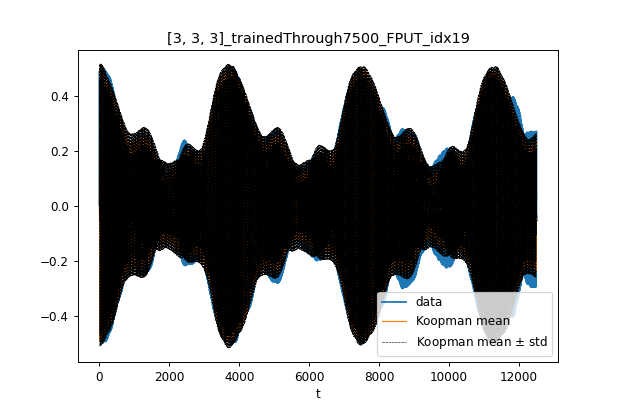

In [32]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
#     plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
#     plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    # plt.plot(mu_vec[slc:], label="real mu")
    # plt.plot(mu_hat[slc:, 0], label="koopman mu")
    # plt.legend()
    # plt.show()
    #
    # plt.plot(sigma_vec[slc:], label="real sigma")
    #     plt.plot(3*sigma_hat[:, dim], label="koopman $3\sigma$", linewidth=0.7)
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [96]:
# plt.figure()
# plt.plot(np.arange(len(oldx), len(oldx) + len(x_original)), x_original, label="2021")
# plt.plot(oldx, label="demand 2005-15")
# plt.legend()
# plt.show()

In [97]:
print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))

actual overall mean: 0  predicted mean: -0.0619289


In [98]:
"mean of a_hat", np.mean(a_hat), "std of a_hat", np.std(a_hat)

('mean of a_hat', 2.3238902, 'std of a_hat', 0.4065727)

In [14]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

In [21]:
z_scores = ((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
# z_scores = ((x[train_through:predict_through] - mean_hat[train_through:]) / std_hat[train_through:])[:8760, 0]
# z_scores /= np.std(z_scores)
z_hist, bin_edges = np.histogram(z_scores, bins=40, density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2

In [22]:
print(np.std(z_scores))
np.mean(z_scores)

0.9739735982666695


-0.10160407016708353

<IPython.core.display.Javascript object>


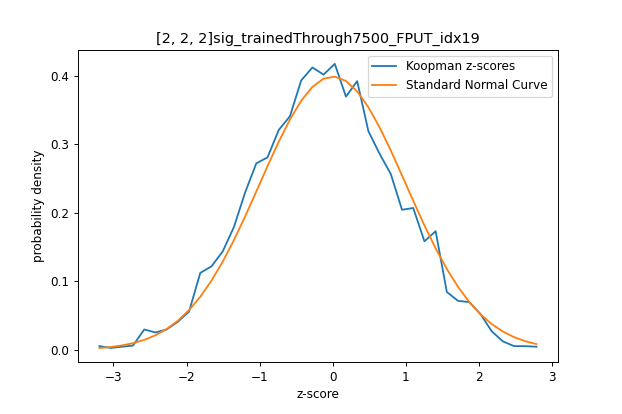

In [23]:
plt.figure()
plt.plot(z_axis, z_hist, label="Koopman z-scores")
plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
plt.title(f"{num_freqs}sig_trainedThrough{train_through}_" + data_name)
plt.xlabel("z-score")
plt.ylabel("probability density")
plt.legend()

In [81]:
mu_hat -= np.mean(mean_hat[:train_through])

# Pinball Loss

In [82]:
def skew_pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [83]:
def normal_pinball_loss(data, mus, sigmas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = norm.ppf(q, loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

<IPython.core.display.Javascript object>


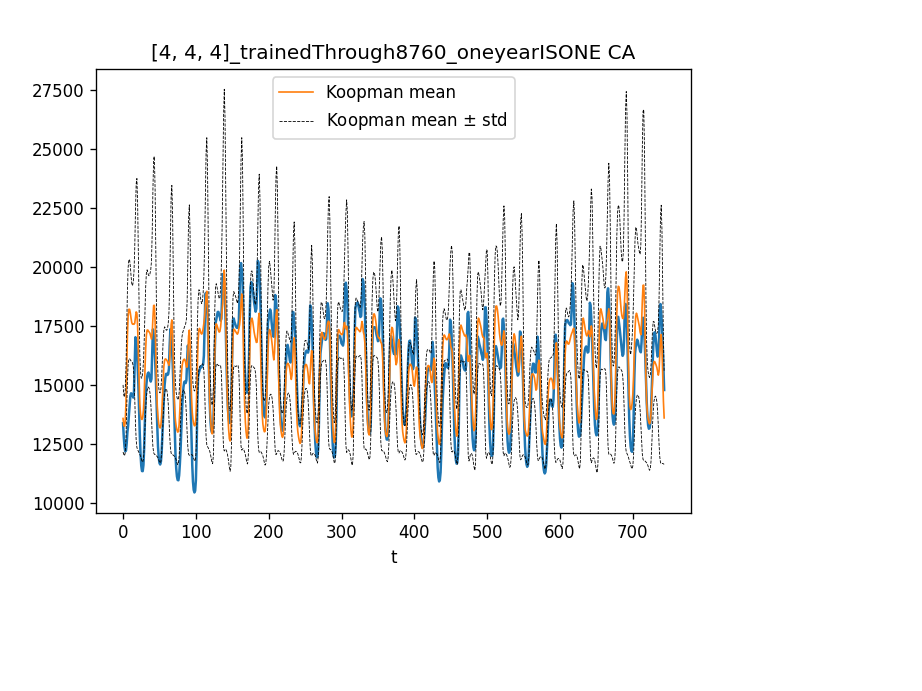

In [84]:
test_start = train_through + delay
# Skew Normal Distribution rescaling
sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
delta = ah / (1 + ah ** 2) ** 0.5
muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
sigh = sigh * rnge
mean_hat = model.mean([muh, sigh, ah])
std_hat = model.std([muh, sigh, ah])

# # Normal Distribution
# sigh = sigma_hat[test_start: predict_through] * rnge
# muh = mu_hat[test_start: predict_through] * rnge + mean
# mean_hat = model.mean([muh, sigh])
# std_hat = model.std([muh, sigh])

plt.figure()
plt.plot(x_original[train_start:][test_start: predict_through])
plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
# plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
# plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
plt.xlabel("t")
plt.legend()
plt.show()

In [85]:
# loss = normal_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh)
loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)
print(loss)

[441.91462544]


In [87]:
import vanilla_benchmark

vanilla_losses = vanilla_benchmark.get_lossesGEFCom(start=train_start, plot=False)
print(vanilla_losses)

ISONE CA
start: 2014-01-01 00:00:00
ME
start: 2014-01-01 00:00:00
RI
start: 2014-01-01 00:00:00
VT
start: 2014-01-01 00:00:00
CT
start: 2014-01-01 00:00:00
NH
start: 2014-01-01 00:00:00
SEMASS
start: 2014-01-01 00:00:00
WCMASS
start: 2014-01-01 00:00:00
NEMASSBOST
start: 2014-01-01 00:00:00
{'ISONE CA': 381.90378149175325, 'ME': 29.5225280460456, 'RI': 24.10316079531464, 'VT': 15.967894087158326, 'CT': 106.84865130851064, 'NH': 36.62805990777599, 'SEMASS': 48.63787072147622, 'WCMASS': 55.24190168505761, 'NEMASSBOST': 80.30352911316842}


In [88]:
1 - loss/vanilla_losses[zone_name]

# with 52 day gap between training and testing
# 1 - loss / 84.2  # WCMASS +25%
# 1 - loss / 122.8  # NEMASSBOST 39.4%
# 1 - loss / 596  # ISONE 19.4%
# VT: +9.2%
# (old--Monday=0) {'ISONE CA': 523.7428637110866, 'ME': 58.71157246544602, 'RI': 36.73051071209801, 'VT': 22.977155005752657, 'CT': 141.30040329213762, 'NH': 63.25224646477936, 'SEMASS': 65.42717786334023, 'WCMASS': 70.82418918073226, 'NEMASSBOST': 110.09485925971588}


array([-0.15713603])

In [68]:
import os

folder = ".\\forecasts\GEFComFirstQualTest"
a_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]alpha.npy"))
mu_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]mu.npy"))
sigma_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]sigma.npy"))

In [141]:
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json") as f:
    all_data1 = json.loads(f.read())
    
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2016.json") as f:
    all_data2 = json.loads(f.read())
    
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2017.json") as f:
    all_data3 = json.loads(f.read())

In [142]:
zone_name = 'WCMASS'

In [143]:
all_data1[zone_name].keys()

dict_keys(['Date', 'Hour', 'DA_DEMD', 'DEMAND', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'DryBulb', 'DewPnt'])

In [144]:
all_data2[zone_name].keys()

dict_keys(['Date', 'Hr_End', 'DA_Demand', 'RT_Demand', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'Dry_Bulb', 'Dew_Point'])

In [145]:
all_data3[zone_name].keys()

dict_keys(['Date', 'Hr_End', 'DA_Demand', 'RT_Demand', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'Dry_Bulb', 'Dew_Point'])

In [146]:
rename_isone = {'Date': 'Date',
        'Hr_End': 'Hour',
        'DA_Demand': 'DA_DEMD',
        'RT_Demand': 'DEMAND',
        'DA_LMP': 'DA_LMP',
        'DA_EC': 'DA_EC',
        'DA_CC': 'DA_CC',
        'DA_MLC': 'DA_MLC',
        'RT_LMP': 'RT_LMP',
        'RT_EC': 'RT_EC',
        'RT_CC': 'RT_CC',
        'RT_MLC': 'RT_MLC',
        'Dry_Bulb': 'DryBulb',
        'Dew_Point': 'DewPnt',
        'System_Load': 'SYSLoad',
        'Reg_Capacity_Price': 'RegCP'
       }
rename = {'Date': 'Date',
        'Hr_End': 'Hour',
        'DA_Demand': 'DA_DEMD',
        'RT_Demand': 'DEMAND',
        'DA_LMP': 'DA_LMP',
        'DA_EC': 'DA_EC',
        'DA_CC': 'DA_CC',
        'DA_MLC': 'DA_MLC',
        'RT_LMP': 'RT_LMP',
        'RT_EC': 'RT_EC',
        'RT_CC': 'RT_CC',
        'RT_MLC': 'RT_MLC',
        'Dry_Bulb': 'DryBulb',
        'Dew_Point': 'DewPnt',
       }

In [147]:
all_data = all_data1.copy()

In [148]:
for zone in all_data.keys():
    if zone == "ISONE CA":
        for quantity in rename_isone.keys():
            name = rename_isone[quantity]
            all_data[zone][name].extend(all_data2[zone][quantity])
            all_data[zone][name].extend(all_data3[zone][quantity])
    else:
        for quantity in rename.keys():
            name = rename[quantity]
            all_data[zone][name].extend(all_data2[zone][quantity])
            
            all_data[zone][name].extend(all_data3[zone][quantity])
            

In [149]:
x = np.array(all_data[zone_name]["DEMAND"])

In [150]:
x1 = (all_data1[zone_name]["DEMAND"])

In [151]:
len(x2), len(x3), len(x)

(8784, 8760, 113952)

In [152]:
import pandas as pd

In [153]:
dates = np.array(list(map(pd.Timestamp, all_data["ISONE CA"]["Date"])))
hours = np.array(list(pd.Timedelta(hours=h-1) for h in all_data["ISONE CA"]["Hour"]))
dates += hours
dates = list(map(str, dates))

In [154]:
for zone in all_data.keys():
    all_data[zone]["Date"] = dates

In [155]:
all_data[zone_name].keys()

dict_keys(['Date', 'Hour', 'DA_DEMD', 'DEMAND', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'DryBulb', 'DewPnt'])

In [156]:
len(all_data[zone]["Date"]) / 8760

13.008219178082191

In [157]:
json_data = json.dumps(all_data)
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017QualAll.json", "w") as f:
    f.write(json_data)